In [802]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares
from scipy.signal import find_peaks



In [803]:
#File paths
m1_neg_file='/Users/christopherwitt/F-Praktikum/NV Centers/Experiment 2/Data/m1-neg_1_05_2/20251029-1146-01_wainteach_gui.dat'
m1_pos_file='/Users/christopherwitt/F-Praktikum/NV Centers/Experiment 2/Data/m1-pos_1_05_2/20251029-1141-34_wainteach_gui.dat'

m2_neg_file='/Users/christopherwitt/F-Praktikum/NV Centers/Experiment 2/Data/m2-neg_+2deg/20251029-1202-01_wainteach_gui.dat'
m2_pos_file='/Users/christopherwitt/F-Praktikum/NV Centers/Experiment 2/Data/m2-pos_+2deg/20251029-1206-52_wainteach_gui.dat'

m3_neg_file='/Users/christopherwitt/F-Praktikum/NV Centers/Experiment 2/Data/m3-neg_-2deg/20251029-1209-37_wainteach_gui.dat'
m3_pos_file='/Users/christopherwitt/F-Praktikum/NV Centers/Experiment 2/Data/m3-pos_-2deg/20251029-1213-17_wainteach_gui.dat'

In [804]:
def load_data(filename):
    df = pd.read_csv(
        filename,
        comment='#',
        delim_whitespace=True,
        encoding='latin1'  # oder alternativ: encoding='ISO-8859-1'
    )
    df.columns = ['Frequenz', 'Voltage']
    Voltage=np.array(df['Voltage'])
    Frequenz=np.array(df['Frequenz'])
    data=[Frequenz,Voltage]
    return data


In [805]:
m1_neg_data = np.array(load_data(m1_neg_file))
m1_pos_data = np.array(load_data(m1_pos_file))

m2_neg_data = np.array(load_data(m2_neg_file))
m2_pos_data = np.array(load_data(m2_pos_file))

m3_neg_data = np.array(load_data(m3_neg_file))
m3_pos_data = np.array(load_data(m3_pos_file))

/var/folders/bg/b44vpd1j713_48yg885ptdvw0000gn/T/ipykernel_2112/3927440244.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/bg/b44vpd1j713_48yg885ptdvw0000gn/T/ipykernel_2112/3927440244.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/bg/b44vpd1j713_48yg885ptdvw0000gn/T/ipykernel_2112/3927440244.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/bg/b44vpd1j713_48yg885ptdvw0000gn/T/ipykernel_2112/3927440244.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(
/var/folders/bg/b44vpd1j713_

In [806]:
from scipy.signal import find_peaks
import numpy as np
from iminuit import Minuit
from iminuit.cost import LeastSquares

def lorentz(x, x0, gamma, A):
    return A * (0.5 * gamma)**2 / ((x - x0)**2 + (0.5 * gamma)**2)

def triple_lorentz(x, x01, g1, A1, x02, g2, A2, x03, g3, A3, offset):
    return (
        lorentz(x, x01, g1, A1) +
        lorentz(x, x02, g2, A2) +
        lorentz(x, x03, g3, A3) +
        offset
    )

def fit_triple_lorentz_auto(x, y, yerr=None):

    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)
    if yerr is None:
        yerr = np.full_like(y,0.000533)

    # --- 1. Drei tiefste Minima suchen ---
    peaks, _ = find_peaks(-y, distance=len(x)/6)
    peaks = peaks[np.argsort(y[peaks])[:3]]  # drei tiefste
    peaks = np.sort(peaks)

    # --- 2. Startparameter schätzen ---
    if len(peaks) < 3:
        print("⚠️ Weniger als 3 Minima gefunden – Zufallsstartwerte verwendet.")
        peaks = np.linspace(x[0], x[-1], 3, dtype=int)

    x0s = x[peaks]
    g_est = (x[-1] - x[0]) / 100
    A_est = np.min(y) - np.mean(y)
    offset = np.mean(y)

    start = dict(
        x01=x0s[0], g1=g_est, A1=A_est,
        x02=x0s[1], g2=g_est, A2=A_est,
        x03=x0s[2], g3=g_est, A3=A_est,
        offset=offset
    )

    # --- 3. Least Squares Fit ---
    least_squares = LeastSquares(x, y, yerr, triple_lorentz)
    m = Minuit(least_squares, **start)
    m.errordef = Minuit.LEAST_SQUARES
    m.migrad()
    m.hesse()

    return m

#alle drei minimum des Fits berechnen und 2 tes zurück geben 
def calculate_minimum(x,fit_result):
    x_fit = np.linspace(np.min(x), np.max(x), 1000)
    y_fit = triple_lorentz(x_fit, *fit_result.values)
    peaks, _ = find_peaks(-y_fit, distance=len(x_fit)/6)
    peak_positions = x_fit[peaks]
    peak_values = y_fit[peaks]

    plt.vlines(peak_positions[1], ymin=np.min(y_fit), ymax=np.max(y_fit)*1.002, colors='green', linestyles='dashed')
    plt.text(peak_positions[1]-1.5*10**7, np.max(y_fit)*1.002, f' {peak_positions[1]/1000000000:.2f} GHz', color='green')


def plot_lorenz_fit(x, y, yerr=None, start_params=None,name=None):
    m=fit_triple_lorentz_auto(x, y, yerr)
    x_fit = np.linspace(np.min(x), np.max(x), 1000)
    y_fit = triple_lorentz(x_fit, *m.values)
    calculate_minimum(x,m)
    plt.plot(x_fit, y_fit, label=name, color='red')
    plt.xlabel('Frequenz (GHz)')
    plt.ylabel('Voltage (V)')




In [807]:


def find_minima_intervals(x, y, n_minima=8, half_window_points=25, plot=True):


    # In numpy-Arrays konvertieren
    x = np.asarray(x, dtype=float)
    y = np.asarray(y, dtype=float)

    # Minima finden → Peaks im invertierten Signal
    peaks, _ = find_peaks(-y, distance=len(x) / (n_minima * 2))

    # Nur die n_minima tiefsten behalten
    if len(peaks) > n_minima:
        sorted_idx = np.argsort(y[peaks])  # tiefste zuerst
        peaks = peaks[sorted_idx[:n_minima]]

    # Nach Frequenz sortieren
    peaks = np.sort(peaks)

    # Indexintervalle bestimmen
    intervals = []
    for p in peaks:
        i_start = max(0, p - half_window_points)
        i_end = min(len(x) - 1, p + half_window_points)
        intervals.append((i_start, i_end))

    # Plot optional
    if plot:
        plt.figure(figsize=(8, 4))
        plt.plot(x, y, 'b-', label="Signal")
        plt.plot(x[peaks], y[peaks], 'ro', label="Gefundene Minima")
        for (i1, i2) in intervals:
            plt.axvspan(x[i1], x[i2], color='orange', alpha=0.2)
        plt.xlabel("Frequenz (Hz)")
        plt.ylabel("Spannung (V)")
        plt.legend()
        plt.title("Automatisch erkannte Minima & Indexintervalle")
        #plt.show()

    return intervals

    



/Users/christopherwitt/Library/Python/3.9/lib/python/site-packages/iminuit/minuit.py:139: ErrordefAlreadySetWarning: cost function has an errordef attribute equal to 1.0, you should not override this with Minuit.errordef
  warnings.warn(msg, ErrordefAlreadySetWarning)


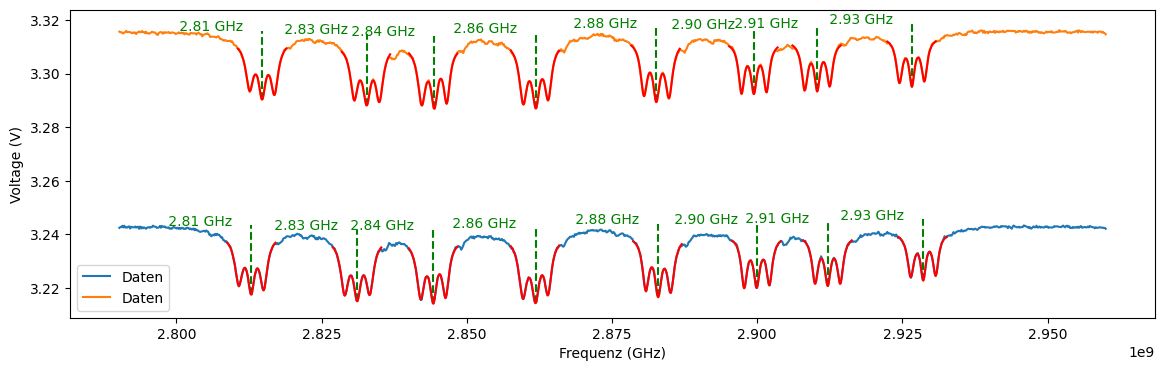

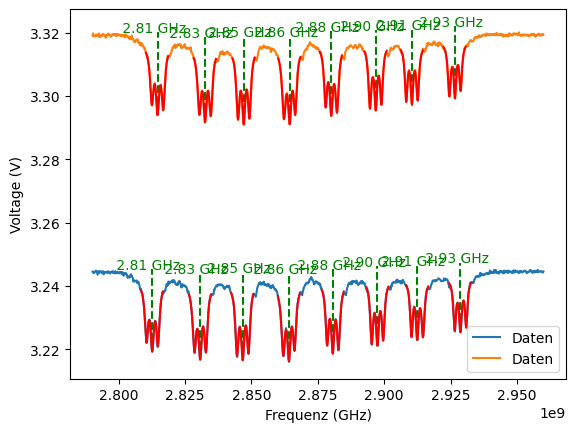

In [808]:
def alalyze_data(data, n_minima=8):
    x = data[0]
    y = data[1]
    #plt.figure(figsize=(14, 4))
    plt.plot(x, y, label='Daten')
    intervalls=find_minima_intervals(x, y, n_minima=8, plot=False)
    for i in range(8):
        plot_lorenz_fit(x[intervalls[i][0]:intervalls[i][1]], y[intervalls[i][0]:intervalls[i][1]])
        plt.legend()
    plt.grid()
    #plt.show()
plt.figure(figsize=(14, 4))
alalyze_data(m1_neg_data)
alalyze_data(m1_pos_data)
plt.show()
#alalyze_data(m2_neg_data)
#alalyze_data(m2_pos_data)
alalyze_data(m3_neg_data)
alalyze_data(m3_pos_data)
plt.show()

